In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math
import os

def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    return df_master

def species_plot(df):
    df = df.replace("__ribosome", "free ribosomes")
    df = df.replace("TTT_charged", "charged tRNA")
    df = df.replace("TTT_uncharged", "uncharged tRNA")
    df_fil = df[(df.species == "charged tRNA") | (df.species == "free ribosomes")]
    g = sns.lineplot(x="time", y="protein", units="seed", hue="species", estimator=None, data=df_fil)
    g.get_legend().set_title(None)

In [124]:
from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def get_average_protein(path_pref, time, max_seed, get_range=False):
    df_master = pd.read_csv(f"{path_pref}_1.tsv")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    # get average species counts for all trials
    df_master = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    if time not in df_master["time"].values:
        time = take_closest(df_master["time"].values, time)
    if not get_range:
        df_master = df_master[(df_master.time == time)] 
    else:
        df_master = df_master[(df_master.time >= time - 100)]
        df_master["tRNA_ss"] = df_master[(df_master.species == "TTT_charged")]["protein"].mean()
        df_master["rib_ss"] = df_master[(df_master.species == "__ribosome")]["protein"].mean()
        df_master = df_master[(df_master.time == time)]
    df_master = df_master.replace("__ribosome", "ribosomes")
    return df_master

In [125]:
from trnasimtools.serialize import SerializeSingleCodonSingleTranscript
from trnasimtools.simulate import SimulateSingleCodonSingleTranscript

In [14]:
rcParams['figure.figsize'] = [10, 5]

In [2]:
!mkdir ../yaml/april-15-2023
!mkdir ../output/april-15-2023

In [8]:
date = "april-15-2023"

## Finding analytical solutions for a single codon/single transcript system

This system consists of a fixed pool of mRNA transcripts, ribosomes, and a single type of tRNA. The rate of protein production depends exclusively on the steady-state concentrations of free ribosomes and charged tRNAs. We will attempt to find analytical solutions to calculate these quantities.

For tRNAs, the conversion between the charged/aminoacylated and uncharged form occurs instantaneously and irreversibly. Generically, this kind of reaction looks like

$A \rightarrow B$ with rate $k_{+}$ and $B \rightarrow A$ with rate $k_{-}$

The correspnding rate equation is

$\frac{d}{dt}\ a(t) = k_{-}b(t) - k_{+}a(t)$ 

and 

$\frac{d}{dt}\ b(t) = k_{+}a(t) - k_{-}b(t)$

Since total concentration is conserved, the concentrations can be derived by writing

$b(t) = T - a(t)$

Where $T$ is the total concentration of the reversible species. Equation 1 can then be re-written as   

$\frac{d}{dt}\ a(t) = k_{-}(T - a(t)) - k_{+}a(t)$

and

$\frac{d}{dt}\ a(t) = k_{-}T - (k_{+} + k_{-})a(t)$ 

The steady-state concentration satisfies 
$0 = k_{-}T - (k_{+} + k_{-})a(t)$

Solving gives
$$
a^{ss} = \frac {k_{-}T}{k_{+}+k_{-}} 
$$

The rate of consumption of charged tRNAs depends on the number of actively translating ribosomes (I think) -> so, the steady-state concentration of active ribosomes, and the ribosome "speed" constant. And then the rate of production depends on the charging rate constant. So if we let charged tRNAs be $a^{ss}$, swapping these in to the generic steady-state equation we have

$$
    \text{tRNA}_{\text{charged}} = \text{tRNA}_{\text{tot}} \times \frac{k_{\text{charge}}}{\text{rib}_{\text{active}} \times k_{\text{speed}} + k_{\text{charge}}}\
$$  

$$
\text{rib}_{\text{active}} = \text{rib}_{\text{tot}} \times \frac{k_{\text{bind}} \times N}{\frac{\text{tRNA}_{\text{charged}}}{N*L}\ + k_{bind} \times N}\
$$

Since these expressions depend on each other, we can subsitute one in for the other and solve the resulting quadratic for the closed-form solution. For ribosomes this is:

$$
    \text{rib}_{\text{active}} = \frac{-u - \sqrt{u^{2} + 4 \times \text{k}_{\text{charge}}\times \text{rib}_{\text{tot}}}}{-2\times\text{k}_{\text{speed}}}
$$

$$
   u = \text{rib}_{\text{tot}}\times \text{k}_{\text{speed}} - \text{k}_{\text{charge}} - \frac{\text{tRNA}_{\text{tot}}\times \text{k}_{\text{charge}}}{\text{k}_{\text{bind}}\times N^{2}\times L}
$$

(the closed form solution for tRNAs is similar)

As a sanity check, first I run one simulation where active ribosomes and tRNAs have non-trivial (not 0 or max) steady-states, and manually check the simulated ribosome steady state against abundances calculated from equation 2 (by just plugging in the value for tRNAs, rather than solving the system).

In [6]:
TS_COPY = 200
RBS_STRENGTH = 10000
TRNA_CHRG_RATE = 100
RB_COPY = 100
TOTAL_TRNA = 100
TIME_LIMIT = 500
TIME_STEP = 5

In [6]:
serializer = SerializeSingleCodonSingleTranscript(transcript_len=100,
                                                   transcript_copy_number=TS_COPY,
                                                   ribosome_binding_rate=RBS_STRENGTH,
                                                   ribosome_copy_number=RB_COPY,
                                                   total_trna=TOTAL_TRNA,
                                                   trna_charging_rate=TRNA_CHRG_RATE
                                                   )
serializer.serialize(f"../yaml/{date}")

In [12]:
configs = f"../yaml/{date}/{serializer.filename()}"
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    cmd = f"python3 singlecodonsingletranscript.py {config} 1 ../output/{date} {TIME_LIMIT} {TIME_STEP}"
    stream.write(cmd)
    stream.write("\n")

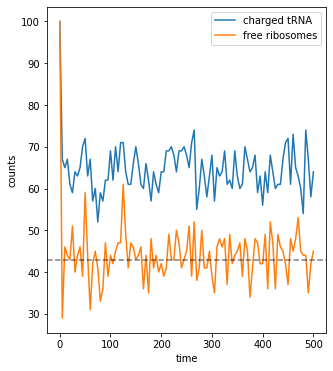

In [20]:
# Read in the simualtion and plot the analytical solution 
rcParams['figure.figsize'] = [5, 6]
df_master = read_sim("../output/april-15-2023/two_codon_single_transcript_200_100_100_10000_100", 1, 1, 1) #should be "one codon"
species_plot(df_master)
#ribosome_plot(df_master)
plt.ylabel("counts")
plt.gca().axhline(43, ls='--', color="black", alpha=0.5)
#plt.gca().axhline(64, ls='--', color="black", alpha=0.5)
plt.savefig(f"../plots/april-15-2023/rbs_10000_chrg_100_rib_line_short.png", bbox_inches="tight")

In [9]:
df = pd.read_csv("../output/april-15-2023/two_codon_single_transcript_200_100_100_10000_100_1.tsv", sep="\t")
df = df.drop(columns = "time")
df.to_csv("test.tsv", index=False, sep="\t")

Here I'm doing the same thing, but for tRNA charging rates ranging from 10^0 to 10^4.

In [7]:
chrg_rates = [1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 2500.0, 5000.0, 7500.0, 10000.0]
for rate in chrg_rates:
    serializer = SerializeSingleCodonSingleTranscript(transcript_len=100,
                                                       transcript_copy_number=TS_COPY,
                                                       ribosome_binding_rate=RBS_STRENGTH,
                                                       ribosome_copy_number=RB_COPY,
                                                       total_trna=TOTAL_TRNA,
                                                       trna_charging_rate=rate
                                                       )
    serializer.serialize(f"../yaml/{date}")

In [19]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for seed in range(1, 4):
            cmd = f"python3 singlecodonsingletranscript.py ../yaml/{date}/{config} {seed} ../output/{date} {TIME_LIMIT} {TIME_STEP} {RB_SPEED}"
            stream.write(cmd)
            stream.write("\n")

In [126]:
chrg_rates = [1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 2500.0, 5000.0, 7500.0, 10000.0]
df_master = None
for rate in chrg_rates:
    path = f"../output/{date}/single_codon_single_transcript_200_100_100_10000_{rate}"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["charging_rate"] = rate
    df_master = tmp if df_master is None else df_master.append(tmp, ignore_index=True)
df_master

,time,species,protein,tRNA_ss,rib_ss,charging_rate
0,496.0,TTT_charged,0.5,0.888889,1.296296,1.0
1,496.0,TTT_uncharged,99.5,0.888889,1.296296,1.0
2,496.0,__proteinX_rbs,193.0,0.888889,1.296296,1.0
3,496.0,ribosomes,1.5,0.888889,1.296296,1.0
4,496.0,proteinX,439.5,0.888889,1.296296,1.0
...,...,...,...,...,...,...
80,500.0,TTT_charged,99.0,99.022727,79.818182,10000.0
81,500.0,TTT_uncharged,1.0,99.022727,79.818182,10000.0
82,500.0,__proteinX_rbs,199.0,99.022727,79.818182,10000.0
83,500.0,ribosomes,79.5,99.022727,79.818182,10000.0


In [127]:
df_rib_only = df_master[(df_master.species == "ribosomes")]
df_tRNA_only = df_master[(df_master.species == "TTT_charged")]

df_filtered = df_master[(df_master.species == "TTT_charged") | (df_master.species == "ribosomes")]
df_filtered = df_filtered.pivot(index = "charging_rate", columns = "species", values = "protein").reset_index()
df_filtered["tRNA predicted"] = (100 * df_filtered["charging_rate"]) / (((100 - df_filtered["ribosomes"]) * 3) + df_filtered["charging_rate"])
df_filtered = pd.melt(df_filtered, id_vars=["charging_rate"], value_vars=["TTT_charged", "tRNA predicted"])

Text(0.5, 0, 'charging rate')

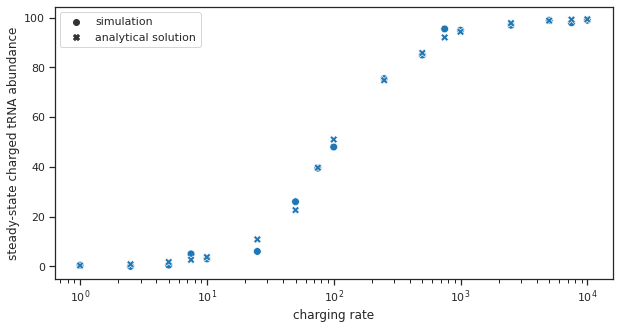

In [11]:
rcParams['figure.figsize'] = [10, 5]
sns.set_theme(style="ticks", palette=None)

df_filtered = df_filtered.replace("TTT_charged", "simulation")
df_filtered = df_filtered.replace("tRNA predicted", "analytical solution")
g = sns.scatterplot(data=df_filtered, x="charging_rate", y="value", style="species", s=60)
g.get_legend().set_title(None)
plt.xscale("log")
plt.ylabel("steady-state charged tRNA abundance")
plt.xlabel("charging rate")
#plt.savefig(f"../plots/april-15-2023/steady_state_ranges.png", bbox_inches="tight")

Finally, I plot both analytical solutions (for ribosomes and tRNAs) against simulation

In [69]:
TS_COPY = 200
RBS_STRENGTH = 10000
RB_COPY = 100
TOTAL_TRNA = 100
SPEED = 3
LEN = 100

In [105]:
def analytical_rib(charging_rate, SPEED):
    AVOGADRO = 6.02214076e23
    VOLUME = 8e-16
    binding_rate = RBS_STRENGTH / (AVOGADRO * VOLUME)
    u = (RB_COPY * SPEED) - charging_rate - ((TOTAL_TRNA * charging_rate)/(binding_rate * (TS_COPY**2) * LEN))
    return 100 - (-u - math.sqrt((u**2) + (4 * charging_rate * RB_COPY))) / (-2 * SPEED)

In [77]:
def analytical_trna(charging_rate):
    AVOGADRO = 6.02214076e23
    VOLUME = 8e-16
    binding_rate = RBS_STRENGTH / (AVOGADRO * VOLUME)
    u = ((charging_rate * TOTAL_TRNA)/(TS_COPY * LEN)) - (RB_COPY * binding_rate * TS_COPY * SPEED) - (charging_rate * binding_rate * TS_COPY)
    return (-u - math.sqrt((u**2) + ((4 * (charging_rate**2) * TOTAL_TRNA * binding_rate)/LEN))) / ((-2 * charging_rate) / (TS_COPY * LEN))

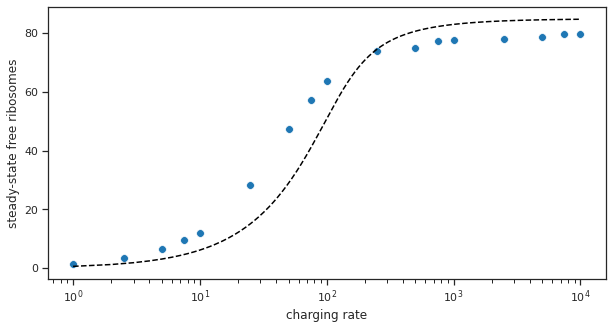

In [113]:
x = np.arange(1, 10000, 1)
r = [analytical_rib(value, 3) for value in x]

sns.set_theme(style="ticks", palette=None)
g = sns.scatterplot(data=df_rib_only, x="charging_rate", y="rib_ss", s=60)
plt.xscale("log")
plt.ylabel("steady-state free ribosomes")
plt.xlabel("charging rate")

#plt.plot(x, y2, 'r--')
plt.plot(x, r, 'k--')
#plt.plot(x, y5, 'b--')

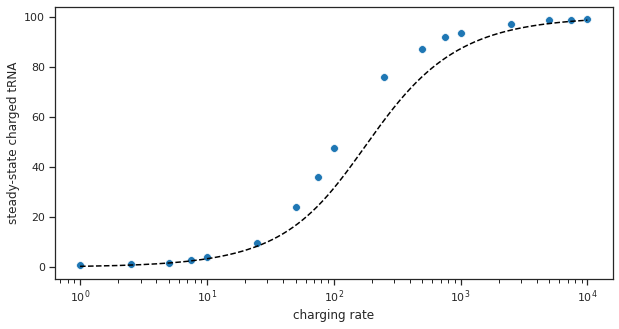

In [114]:
x = np.arange(1, 10000, 1)
t = [f2(value) for value in x]

sns.set_theme(style="ticks", palette=None)
g = sns.scatterplot(data=df_tRNA_only, x="charging_rate", y="tRNA_ss", s=60)
plt.xscale("log")
plt.ylabel("steady-state charged tRNA")
plt.xlabel("charging rate")

plt.plot(x, t, 'k--')

Text(0.5, 0, 'charged tRNAs')

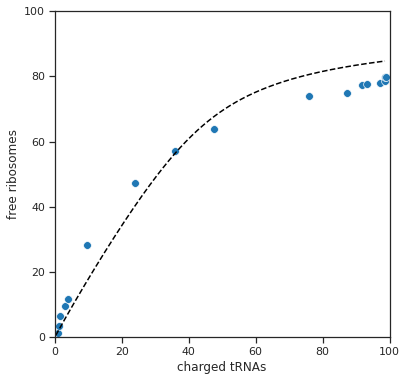

In [135]:
rcParams['figure.figsize'] = [6, 6]
g = sns.scatterplot(data=df_rib_only, x="tRNA_ss", y="rib_ss", s=60)
plt.plot(t, r, 'k--')
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.ylabel("free ribosomes")
plt.xlabel("charged tRNAs")
#plt.xscale("log")

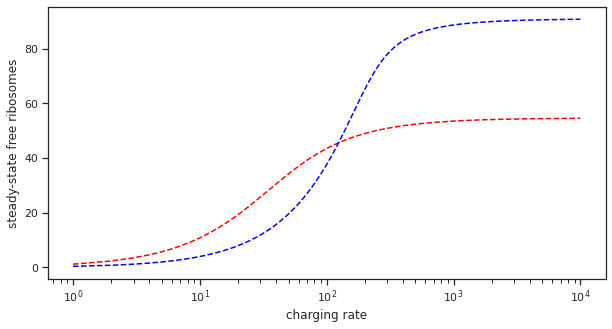

In [66]:
x = np.arange(1, 10000, 1)
y1 = [f(value, 1) for value in x]
y3 = [f(value, 2.3) for value in x]
y5 = [f(value, 5) for value in x]

sns.set_theme(style="ticks", palette=None)
#g = sns.scatterplot(data=df_rib_only, x="charging_rate", y="protein", s=60)
plt.xscale("log")
plt.ylabel("steady-state free ribosomes")
plt.xlabel("charging rate")

plt.plot(x, y1, 'r--')
#plt.plot(x, y3, 'k--')
plt.plot(x, y5, 'b--')